In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import FeatureAgglomeration
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')

In [2]:
# Открываем тренировочные данные
data_train = pd.read_csv('train.csv')
print('Размер train: ', data_train.shape)
data_train.head()

Размер train:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Открываем тестовые данные (для изменения для послудующей проверки)
data_test = pd.read_csv('test.csv')
print('Размер test: ', data_test.shape)
data_test.head()

Размер test:  (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# Количество столбцов каждого типа
data_train.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [5]:
# Функция которая вычисляет количество пропущенных значений в столбце (а так же процент)
def missing_values_table(df):
        # Всего прощенных значений
        mis_val = df.isnull().sum()
        
        # Процент пропущенных значений
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Составление таблицы результатов
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        
        # Создание шапки таблицы (наименование столбцов)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировать таблицу по проценту отсутствующих по убыванию
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        
        # Распечатать информацию
        print ("Выбранные вами данные имеют " + str(df.shape[1]) + " столбца.\n"      
            "Из них " + str(mis_val_table_ren_columns.shape[0]) +
              " столбцы с пропущенными значениями.")
        
        return mis_val_table_ren_columns

In [6]:
# Статистика по отсутствующим значениям
missing_values_train = missing_values_table(data_train)
missing_values_train.tail()

Выбранные вами данные имеют 12 столбца.
Из них 3 столбцы с пропущенными значениями.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [7]:
# Заполняем отсутствующие значения модой
data_train['Age'] = data_train['Age'].fillna(data_train['Age'].mode()[0])
data_train['Embarked'] = data_train['Embarked'].fillna(data_train['Embarked'].mode()[0])

In [8]:
# Статистика по отсутствующим значениям
missing_values_test = missing_values_table(data_test)
missing_values_test.tail()

Выбранные вами данные имеют 11 столбца.
Из них 3 столбцы с пропущенными значениями.


,Missing Values,% of Total Values
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


In [9]:
# Заполняем отсутствующие значения модой
data_test['Age'] = data_test['Age'].fillna(data_test['Age'].mode()[0])
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].mode()[0])

In [10]:
# Удалим ненужные данные 
# 'PassengerId' - сохраним на вывод и удалим
id_pas = data_test['PassengerId']
survive = data_train['Survived']

# 'Survived' - из-за того что используем unsupervised learning
# 'Name', 'Ticket' - не имеют пользы, 'Cabin' - много пропущенных значений
data_train.drop(['PassengerId','Survived','Name','Ticket','Cabin'], axis='columns', inplace=True)
data_test.drop(['PassengerId','Name','Ticket','Cabin'], axis='columns', inplace=True)

In [11]:
# Перевод категориальных значений
data_train = pd.get_dummies(data_train)
data_test = pd.get_dummies(data_test)

In [12]:
data_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [13]:
data_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1


array([[<AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'Sex_female'}>],
       [<AxesSubplot:title={'center':'Sex_male'}>,
        <AxesSubplot:title={'center':'Embarked_C'}>,
        <AxesSubplot:title={'center':'Embarked_Q'}>],
       [<AxesSubplot:title={'center':'Embarked_S'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

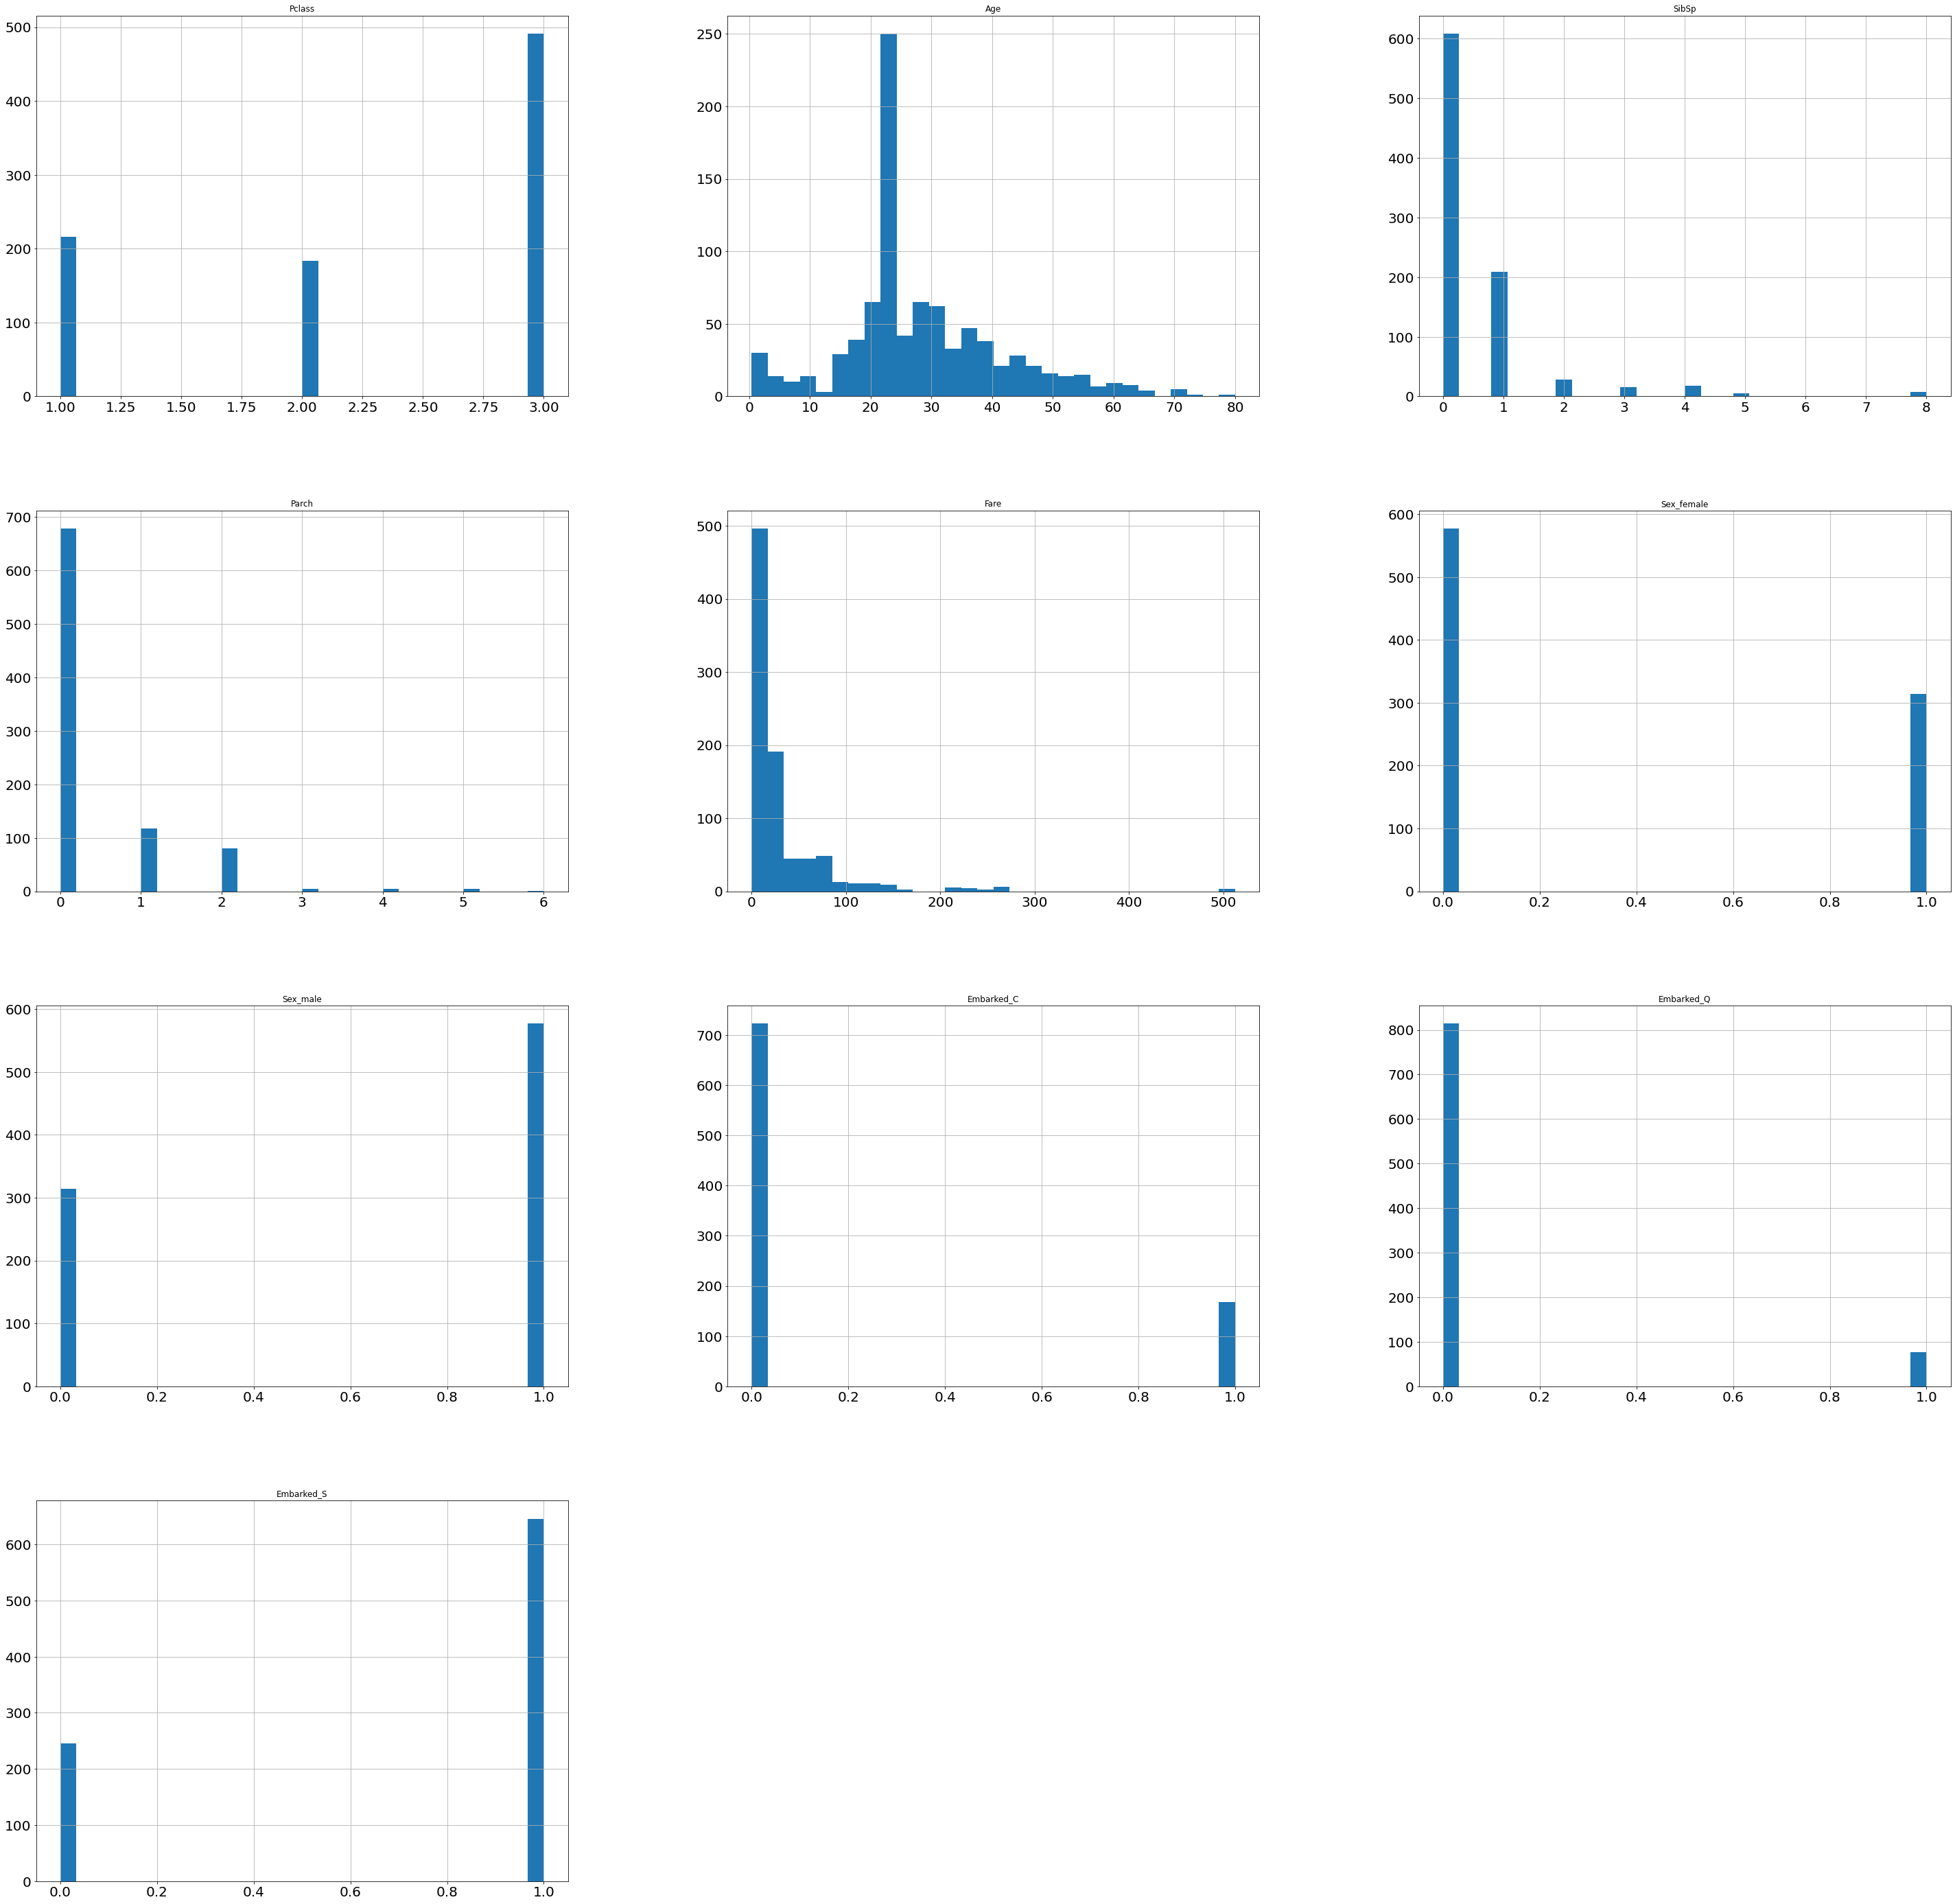

In [14]:
abs(data_train).hist(figsize=(50, 50), bins=30, xlabelsize=20, ylabelsize=20)

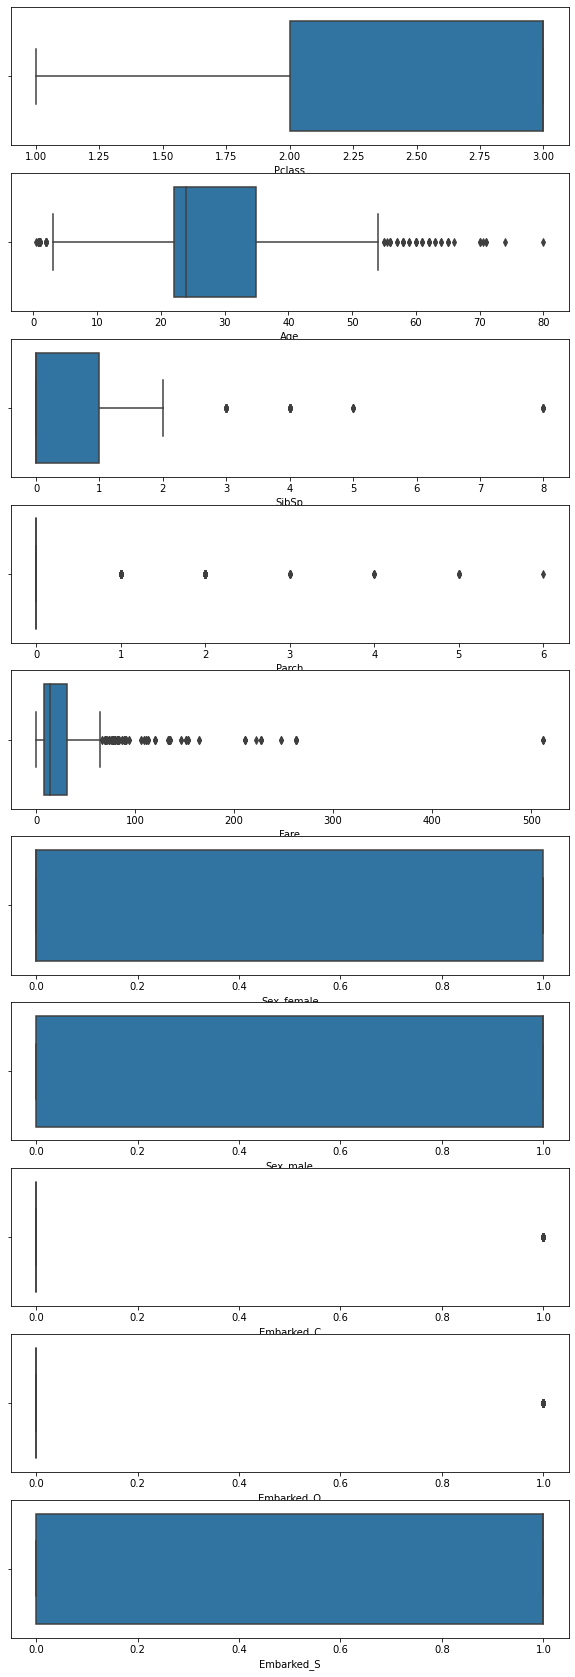

In [15]:
features = data_train.columns
fig, axes = plt.subplots(nrows=len(features), ncols=1)
fig.set_size_inches(10, 30)
for i, col in enumerate(features):
    sns.boxplot(data_train[col], ax=axes[i])
plt.show()

Размер обучающих данных:  (891, 10)
Размер тестовых данных:  (418, 10)


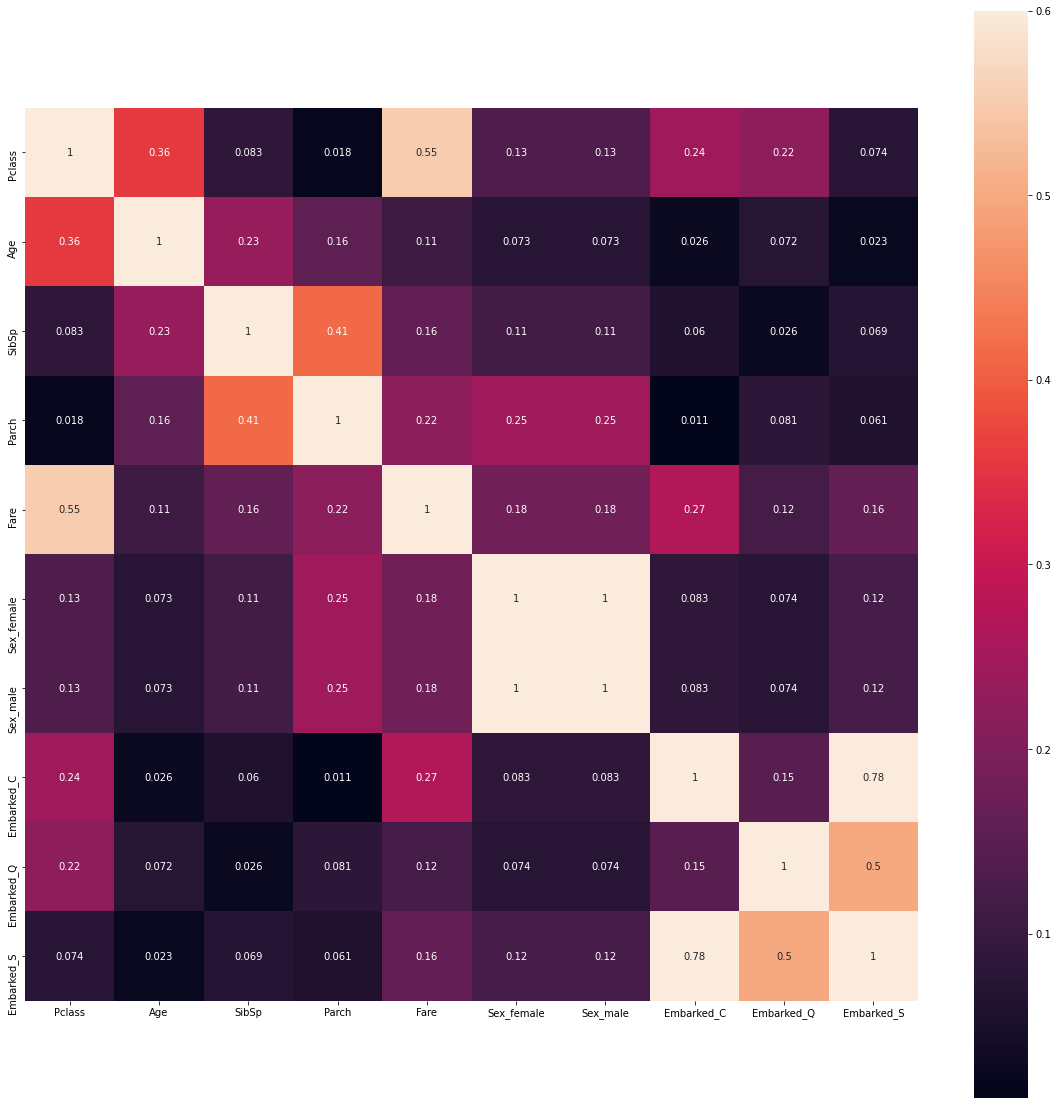

In [16]:
correlation_matrix = abs(data_train.corr())
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, vmax=0.6, square=True, annot=True)
print('Размер обучающих данных: ', data_train.shape)
print('Размер тестовых данных: ', data_test.shape)

Размер обучающих данных:  (891, 9)
Размер тестовых данных:  (418, 9)


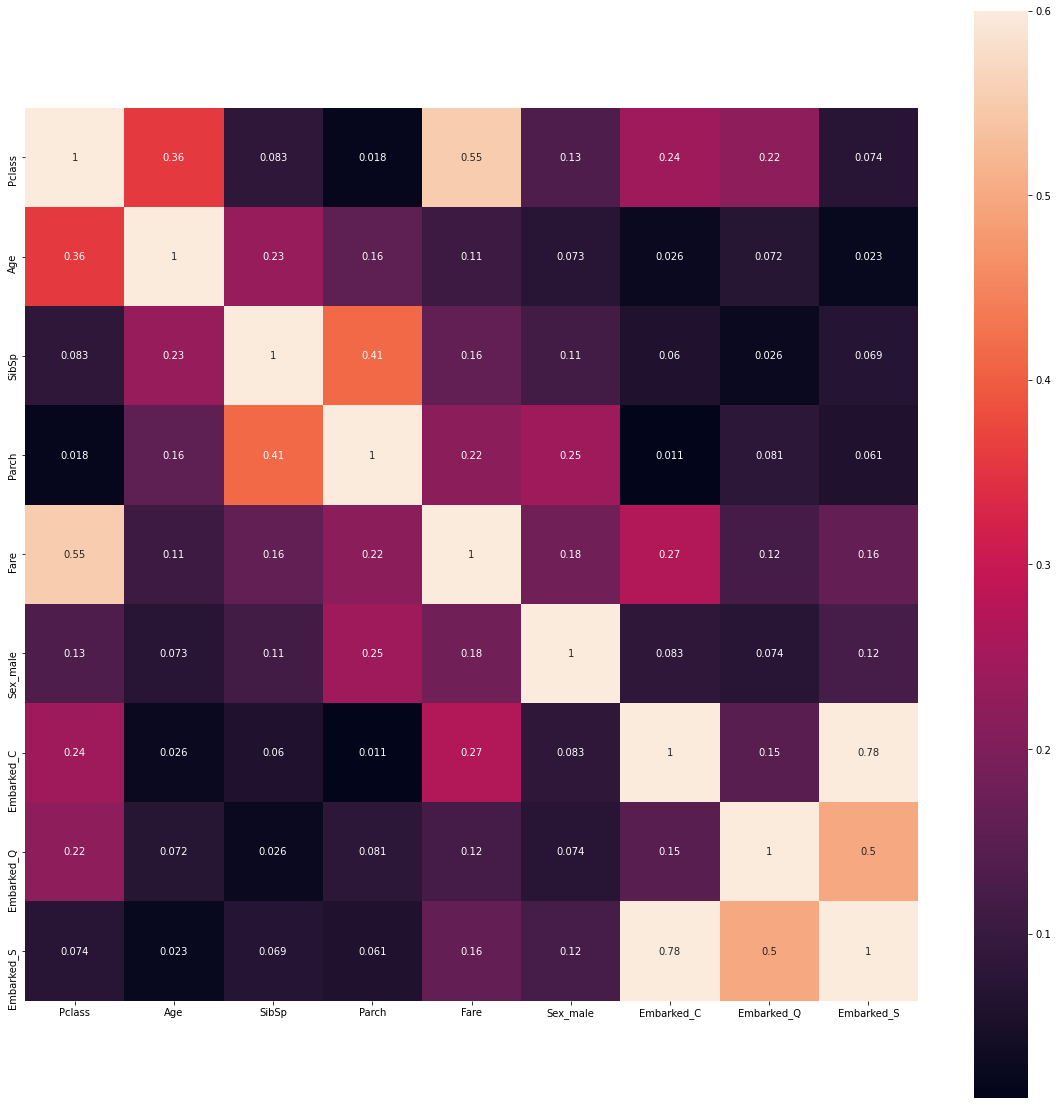

In [17]:
data_train.drop(['Sex_female'], axis='columns', inplace=True)
data_test.drop(['Sex_female'], axis='columns', inplace=True)

correlation_matrix = abs(data_train.corr())
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, vmax=0.6, square=True, annot=True)
print('Размер обучающих данных: ', data_train.shape)
print('Размер тестовых данных: ', data_test.shape)

In [18]:
data_train

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,0,1
1,1,38.0,1,0,71.2833,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,1
4,3,35.0,0,0,8.0500,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,1,0,0,1
887,1,19.0,0,0,30.0000,0,0,0,1
888,3,24.0,1,2,23.4500,0,0,0,1
889,1,26.0,0,0,30.0000,1,1,0,0


In [19]:
# KMeans
def kmeans_result(data_train, data_test, max_iter, n_init, tolerance):
    plt.figure(figsize=(12, 12))
    scaler = StandardScaler()
    data_train_scaled = scaler.fit_transform(data_train)
    data_test_scaled = scaler.fit_transform(data_test)
    
    kmeans = KMeans(max_iter=max_iter, n_clusters=2, n_init=n_init, tol=tolerance)
    tsne = TSNE()
    
    data_train_plot = kmeans.fit(data_train_scaled)
    
    data_train_plot = kmeans.transform(data_train_scaled)
    data_test_plot = kmeans.transform(data_test_scaled)
    
    data_train_plot_tsne = tsne.fit_transform(data_train_scaled)
    data_test_plot_tsne = tsne.fit_transform(data_test_scaled)
    
    result_train = kmeans.labels_
    result_test = kmeans.predict(data_test_scaled)
    
    
    print("Accuracy score:",accuracy_score(survive, kmeans.labels_))
    print(pd.DataFrame(classification_report(survive, kmeans.labels_, output_dict=True)))
    
    plt.subplot(221)
    plt.scatter(data_train_plot[:, 0], data_train_plot[:, 1], c=result_train)
    plt.title("Train data")
    
    plt.subplot(222)
    plt.scatter(data_test_plot[:, 0], data_test_plot[:, 1], c=result_test )
    plt.title("Test data")
    
    plt.subplot(223)
    plt.scatter(data_train_plot_tsne[:, 0], data_train_plot_tsne[:, 1], c=result_train)
    plt.title("Train data")
    
    plt.subplot(224)
    plt.scatter(data_test_plot_tsne[:, 0], data_test_plot_tsne[:, 1], c=result_test )
    plt.title("Test data")
    
     # Make the submission dataframe
    submission = pd.DataFrame({'PassengerId': id_pas, 'Survived': result_test})
    submission.to_csv('submission_KMeans.csv', index = False)
    
    plt.show()

Accuracy score: 0.23007856341189675
                    0           1  accuracy   macro avg  weighted avg
precision    0.302594    0.183824  0.230079    0.243209      0.257005
recall       0.191257    0.292398  0.230079    0.241827      0.230079
f1-score     0.234375    0.225734  0.230079    0.230054      0.231058
support    549.000000  342.000000  0.230079  891.000000    891.000000


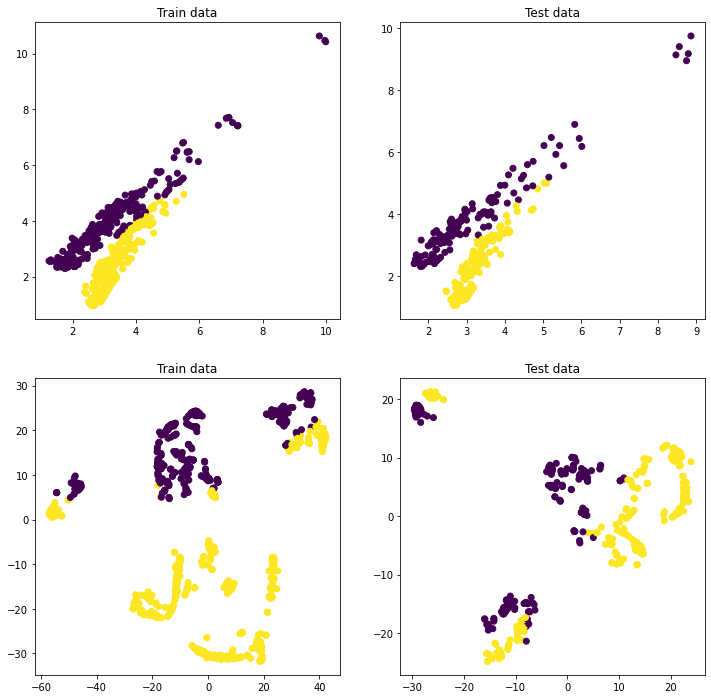

Accuracy score: 0.6924803591470258
                    0           1  accuracy   macro avg  weighted avg
precision    0.704309    0.655963   0.69248    0.680136      0.685752
recall       0.863388    0.418129   0.69248    0.640758      0.692480
f1-score     0.775777    0.510714   0.69248    0.643246      0.674036
support    549.000000  342.000000   0.69248  891.000000    891.000000


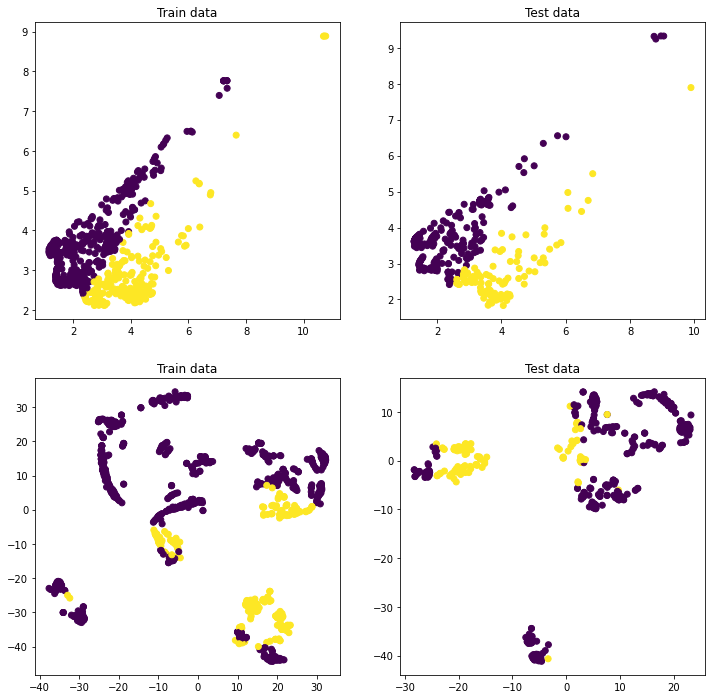

Accuracy score: 0.6172839506172839
                    0           1  accuracy   macro avg  weighted avg
precision    0.660991    0.502041  0.617284    0.581516      0.599980
recall       0.777778    0.359649  0.617284    0.568713      0.617284
f1-score     0.714644    0.419080  0.617284    0.566862      0.601195
support    549.000000  342.000000  0.617284  891.000000    891.000000


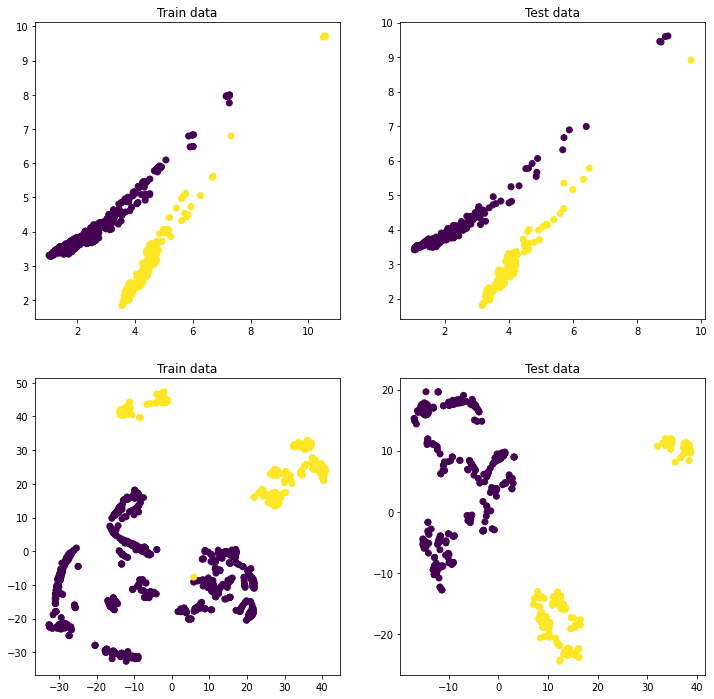

Accuracy score: 0.38271604938271603
                    0           1  accuracy   macro avg  weighted avg
precision    0.497959    0.339009  0.382716    0.418484      0.436948
recall       0.222222    0.640351  0.382716    0.431287      0.382716
f1-score     0.307305    0.443320  0.382716    0.375312      0.359513
support    549.000000  342.000000  0.382716  891.000000    891.000000


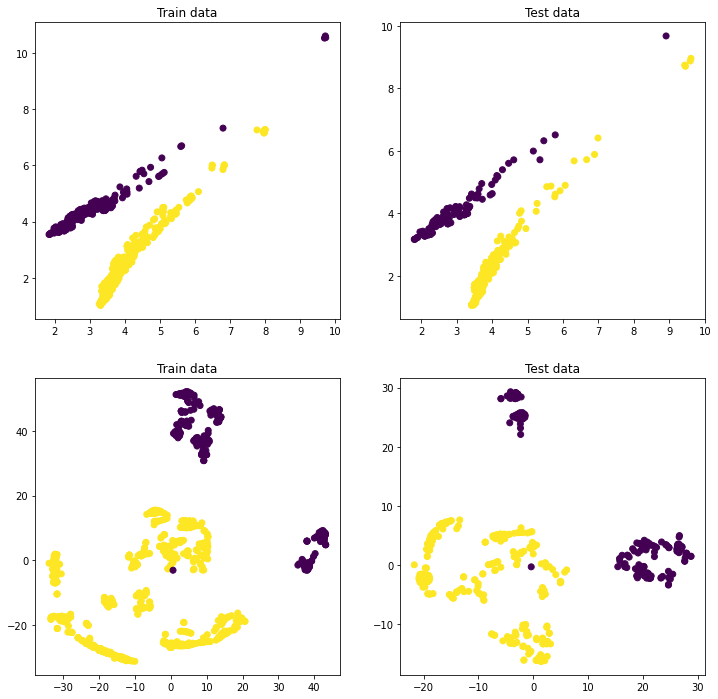

In [20]:
kmeans_result(data_train, data_test, 1000,1,0.1)
kmeans_result(data_train, data_test, 10000,1,0.01)
kmeans_result(data_train, data_test, 10000,10,0.001)
kmeans_result(data_train, data_test, 10000,10,0.0001)

In [21]:
# AgglomerativeClustering
def Agglomerative_result(data_train, data_test, linkage):
    plt.figure(figsize=(12, 12))
    scaler = StandardScaler()
    
    data_train_scaled = scaler.fit_transform(data_train)
    data_test_scaled = scaler.fit_transform(data_test)
    
    #kmeans = KMeans(max_iter=max_it, n_clusters=2, n_init=n_in, tol=tolerance)
    tsne = TSNE()
    aggl = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = linkage)
    
    data_train_plot = aggl.fit(data_train_scaled)
    result_train = aggl.labels_
    
    result_test = data_test_plot = aggl.fit_predict(data_test_scaled)
    #result_test = aggl.labels_
    
    data_train_plot_tsne = tsne.fit_transform(data_train_scaled)
    data_test_plot_tsne = tsne.fit_transform(data_test_scaled)
    
    
    print("Accuracy score:",accuracy_score(survive, result_train))
    print(pd.DataFrame(classification_report(survive, result_train, output_dict=True)))
    
    plt.subplot(221)
    plt.scatter(data_train_plot_tsne[:, 0], data_train_plot_tsne[:, 1], c=result_train)
    plt.title("Train data")
    
    plt.subplot(222)
    plt.scatter(data_test_plot_tsne[:, 0], data_test_plot_tsne[:, 1], c=result_test )
    plt.title("Test data")
    
     # Make the submission dataframe
    submission = pd.DataFrame({'PassengerId': id_pas, 'Survived': result_test})
    submission.to_csv('submission_Aggl.csv', index = False)
    
    plt.show()


Accuracy score: 0.38159371492704824
                    0           1  accuracy   macro avg  weighted avg
precision    0.495902    0.338485  0.381594    0.417193      0.435479
recall       0.220401    0.640351  0.381594    0.430376      0.381594
f1-score     0.305170    0.442872  0.381594    0.374021      0.358025
support    549.000000  342.000000  0.381594  891.000000    891.000000


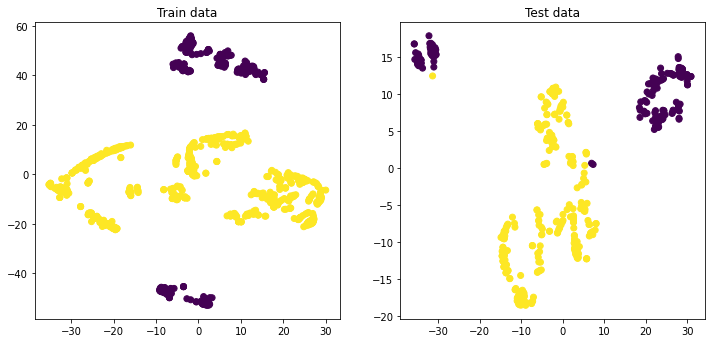

Accuracy score: 0.3782267115600449
                    0           1  accuracy   macro avg  weighted avg
precision    0.307692    0.379271  0.378227    0.343482      0.335167
recall       0.007286    0.973684  0.378227    0.490485      0.378227
f1-score     0.014235    0.545902  0.378227    0.280068      0.218309
support    549.000000  342.000000  0.378227  891.000000    891.000000


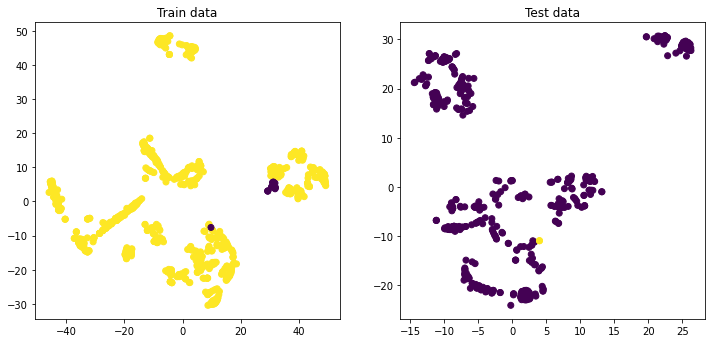

Accuracy score: 0.6195286195286195
                    0           1  accuracy   macro avg  weighted avg
precision    0.618243    1.000000  0.619529    0.809122      0.764776
recall       1.000000    0.008772  0.619529    0.504386      0.619529
f1-score     0.764092    0.017391  0.619529    0.390742      0.477480
support    549.000000  342.000000  0.619529  891.000000    891.000000


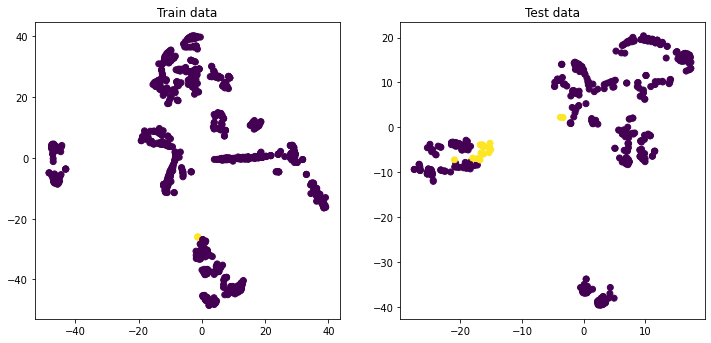

Accuracy score: 0.6195286195286195
                    0           1  accuracy   macro avg  weighted avg
precision    0.618243    1.000000  0.619529    0.809122      0.764776
recall       1.000000    0.008772  0.619529    0.504386      0.619529
f1-score     0.764092    0.017391  0.619529    0.390742      0.477480
support    549.000000  342.000000  0.619529  891.000000    891.000000


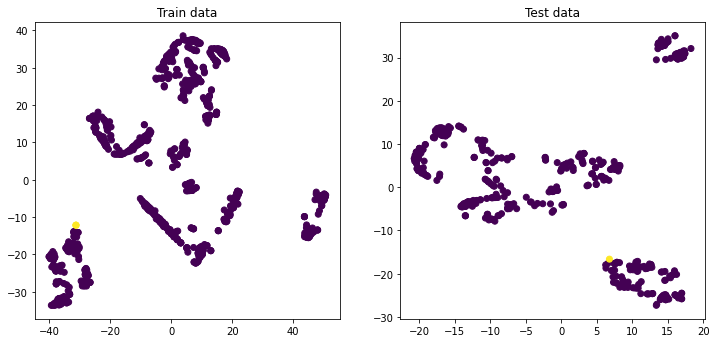

In [22]:
Agglomerative_result(data_train, data_test, 'ward')
Agglomerative_result(data_train, data_test, 'average')
Agglomerative_result(data_train, data_test, 'complete')
Agglomerative_result(data_train, data_test, 'single')

In [23]:
# DBSCAN
def DBSCAN_result(data_train, data_test, eps):
    plt.figure(figsize=(12, 12))
    scaler = StandardScaler()
    
    data_train_scaled = scaler.fit_transform(data_train)
    data_test_scaled = scaler.fit_transform(data_test)
    
    #kmeans = KMeans(max_iter=max_it, n_clusters=2, n_init=n_in, tol=tolerance)
    tsne = TSNE()
    db = DBSCAN(eps = eps, min_samples = 2)
    
    data_train_plot = db.fit(data_train_scaled)
    result_train = db.labels_
    
    result_test = data_test_plot = db.fit_predict(data_test_scaled)
    #result_test = db.labels_
    
    data_train_plot_tsne = tsne.fit_transform(data_train_scaled)
    data_test_plot_tsne = tsne.fit_transform(data_test_scaled)
    
    
    print("Accuracy score:",accuracy_score(survive, result_train))
    print(pd.DataFrame(classification_report(survive, result_train, output_dict=True)))
    
    plt.subplot(221)
    plt.scatter(data_train_plot_tsne[:, 0], data_train_plot_tsne[:, 1], c=result_train)
    plt.title("Train data")
    
    plt.subplot(222)
    plt.scatter(data_test_plot_tsne[:, 0], data_test_plot_tsne[:, 1], c=result_test )
    plt.title("Test data")
    
     # Make the submission dataframe
    submission = pd.DataFrame({'PassengerId': id_pas, 'Survived': result_test})
    submission.to_csv('submission_DBSCAN.csv', index = False)
    
    plt.show()
    

Accuracy score: 0.5791245791245792
            -1           0           1    2    3  accuracy   macro avg  \
precision  0.0    0.660465    0.545455  0.0  0.0  0.579125    0.241184   
recall     0.0    0.775956    0.263158  0.0  0.0  0.579125    0.207823   
f1-score   0.0    0.713568    0.355030  0.0  0.0  0.579125    0.213719   
support    0.0  549.000000  342.000000  0.0  0.0  0.579125  891.000000   

           weighted avg  
precision      0.616320  
recall         0.579125  
f1-score       0.575947  
support      891.000000  


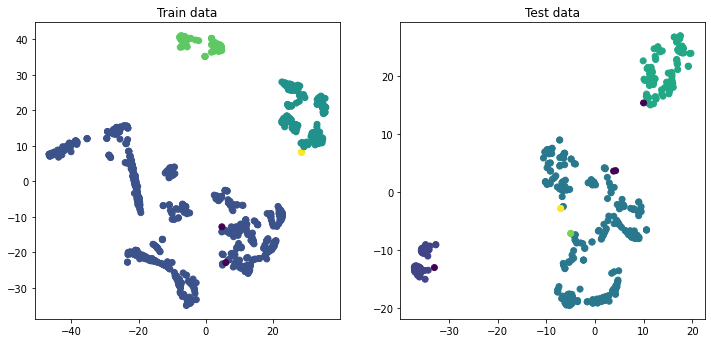

Accuracy score: 0.6195286195286195
                    0           1  accuracy   macro avg  weighted avg
precision    0.618243    1.000000  0.619529    0.809122      0.764776
recall       1.000000    0.008772  0.619529    0.504386      0.619529
f1-score     0.764092    0.017391  0.619529    0.390742      0.477480
support    549.000000  342.000000  0.619529  891.000000    891.000000


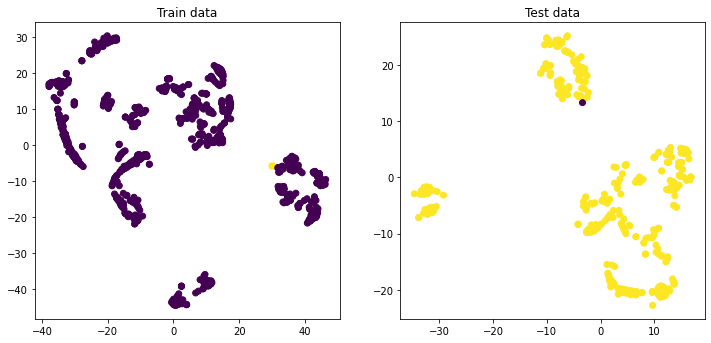

Accuracy score: 0.6195286195286195
                    0           1  accuracy   macro avg  weighted avg
precision    0.618243    1.000000  0.619529    0.809122      0.764776
recall       1.000000    0.008772  0.619529    0.504386      0.619529
f1-score     0.764092    0.017391  0.619529    0.390742      0.477480
support    549.000000  342.000000  0.619529  891.000000    891.000000


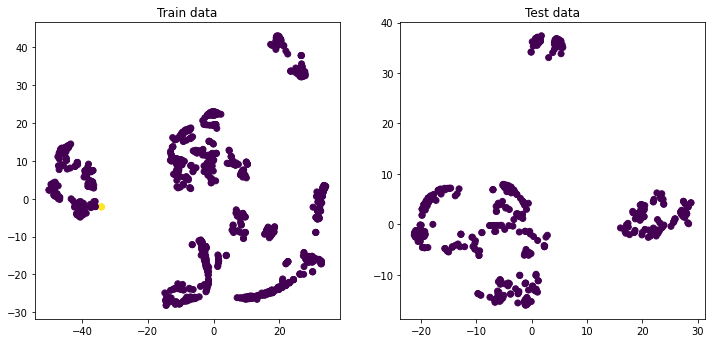

Accuracy score: 0.6161616161616161
                    0      1  accuracy   macro avg  weighted avg
precision    0.616162    0.0  0.616162    0.308081      0.379655
recall       1.000000    0.0  0.616162    0.500000      0.616162
f1-score     0.762500    0.0  0.616162    0.381250      0.469823
support    549.000000  342.0  0.616162  891.000000    891.000000


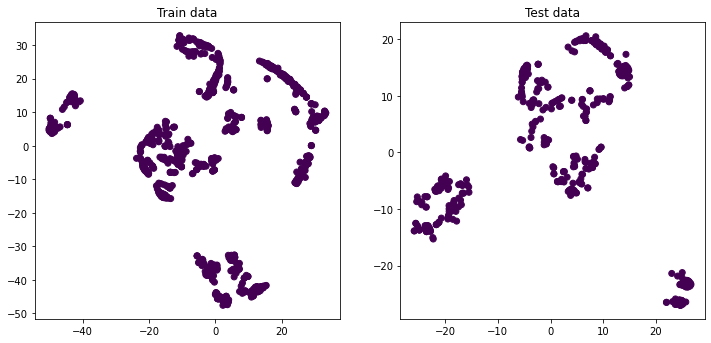

In [24]:
DBSCAN_result(data_train, data_test, 3)
DBSCAN_result(data_train, data_test, 4.37)
DBSCAN_result(data_train, data_test, 5)
DBSCAN_result(data_train, data_test, 7)